<a href="https://colab.research.google.com/github/ian-byrne/MADSmilestone2/blob/main/Supervised_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning: Clock Drawing Image Classification with Convolutional Neural Networks
### Stacey Beck and Ian Byrne

- Split data into sets of Training (x = image arrays ; y = labels), Test (~10% image arrays), and Validation (~10% of the Training). 
- Build CNN using Pytorch for Training and Test:
  - Specify CUDA
  - 2D convolution, Normalization (for faster training), Non-linear Activation Function (ex. RELU), Max Pooling (downsampling to reduce learned parameters).
  - Define Layers 
  - Build Forward and backward pass
  - Define optimizer (due to many - deep - nodes) ex) ADAM
  - Calculate Loss (BCE)
  - Calculate Accuracy, Precision, Recall (Confusion Matrix)
  - Plot ROC and print Confusion Matrix



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/ian-byrne/MADSmilestone2.git

# Change directory into cloned repo
%cd MADSmilestone2

# List repo contents
#!ls

Cloning into 'MADSmilestone2'...
remote: Enumerating objects: 665, done.
remote: Counting objects: 100% (665/665), done.
remote: Compressing objects: 100% (559/559), done.
remote: Total 665 (delta 358), reused 229 (delta 97), pack-reused 0
Receiving objects: 100% (665/665), 5.53 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (358/358), done.
/content/MADSmilestone2


In [ ]:
!pip install torchmetrics boto3

# General Libraries
import pandas as pd
import numpy as np
import ast
import logging
import os
import boto3
from botocore.exceptions import ClientError
import requests
import botocore
import tempfile


# Custom Libraries
import Loading.load_data as ld
import ImagePlayground.Images

# Pytroch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchmetrics

# To Evaluate model
from tqdm import tqdm
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# To visualize model
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage.io import imread

# To split the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

     |████████████████████████████████| 282 kB 15.0 MB/s 
     |████████████████████████████████| 131 kB 86.4 MB/s 
     |████████████████████████████████| 7.9 MB 75.5 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 138 kB 99.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# also import keys for aws connection
from gdrive.MyDrive.Colab_Notebooks.clocks_aws_config import clockss3
pubkey = clockss3['accessCode']
seckey = clockss3['secretCode']
client = boto3.client('s3', aws_access_key_id=pubkey, aws_secret_access_key=seckey)
#response = client.list_buckets()

In [ ]:
#!rm -rf /content/MADSmilestone2

# Build CNN Model using Pytorch


### Building and Training
Architecture choices influenced from: 

https://www.analyticsvidhya.com/blog/2018/12/guide-convolutional-neural-network-cnn/

https://medium.datadriveninvestor.com/five-powerful-cnn-architectures-b939c9ddd57b

https://towardsdatascience.com/how-does-sparse-convolution-work-3257a0a8fd1

In [ ]:
# Define some of the hyperparameters and training variables
#epochs = 2
train_batch_size = 8
val_batch = 4
test_batch = 1
learning_rate = 1e-3
kernel_size = 3
stride = 1
padding = 1 #2*floor(3/2)
weight_decay = 1e-5


# Define file extension to use for new data saves
extension_ = "4_fix"

# Normalize data if rgb and set rgb_val to True to convert 
normalize_ = 'False'

# Define which round to get data from
rnd = 7

# Use numpy data
numpy_ = False 

# Define model extensions for naming file (which model do we want to train on)
model_ext = "3"
#m = 'First model'
m = 'pre-trained'
#m = 'pre-trained-res'
#m = 'resnet'


In [ ]:
if numpy_ == "True":
  # Load numpy array files, add dimension of 1 for gray scale, and zip images and labels 
  # get zipped im label and separate label tensors
  
  tr_im_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/balanced_training.npy"
  tr_lb_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/balanced_train_labels.npy"
  val_im_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_im_nobal.npy"
  val_lb_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_labels_im_nobal.npy"
  tst_im_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/test_im_nobal.npy"
  tst_lb_path = "/content/gdrive/MyDrive/Colab Notebooks/numpy_files/Dementia_label_data/val_labels_im_nobal.npy"

  train_set, y_train_tensor = ld.load_np_files(tr_im_path, tr_lb_path)
  val_set, y_val_tensor = ld.load_np_files(val_im_path, val_lb_path)
  test_set, y_test_tensor = ld.load_np_files(tst_im_path, tst_lb_path)
  """
  #
  #round_val = [1,2,3,4,5,6,7,8,9,10]

  #for rnd in round_val:
    dataset = ResizedClocks(rnd, dictionary[rnd], transform = transforms.ToTensor())

  #print(len(dataset))
  train_size = int(0.9 * len(dataset))
  test_size = int((len(dataset) - train_size)/2)
  #print(train_size)
  #print(test_size)

  val_size = (len(dataset) - train_size - test_size)
  #print(val_size)
  train_set, val_set, test_set = torch.utils.data.random_split(dataset,[train_size, val_size, test_size] )
  """
else:
  path = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/train_dict_nhat.txt'
  cust_file = open(path, "r")
  #print(cust_file.readline())
  contents = cust_file.read()
  dictionarytr = ast.literal_eval(contents)
  cust_file.close()

  path1 = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/val_dict_nhat.txt'
  cust_file = open(path1, "r")
  #print(cust_file.readline())
  contents = cust_file.read()
  dictionaryv = ast.literal_eval(contents)
  cust_file.close()

  path2 = '/content/MADSmilestone2/Data/Dictionaries/dementia_label_dicts/test_dict_nhat.txt'
  cust_file = open(path2, "r")
  #print(cust_file.readline())
  contents = cust_file.read()
  dictionaryts = ast.literal_eval(contents)
  cust_file.close()

In [ ]:
for id, val in dictionarytr.items():
  print("Round {} length is {}".format(str(id), str(len(val))))

Round 5 length is 3181
Round 2 length is 2525
Round 1 length is 3379
Round 10 length is 1660
Round 3 length is 2021
Round 7 length is 2444
Round 8 length is 2123
Round 9 length is 1966
Round 4 length is 1968
Round 6 length is 2733


In [ ]:
class ResizedClocks():
    #Resized clock drawing dataset

    def __init__(self, round, round_labels, rgb = None, transform = None):
        
       # Args:
           # round (int): Round to grab images from. 
           # values (list of tuples): Corresponding values for the round.
        
        self.round = round
        self.vals = round_labels
        self.client = boto3.client('s3', 
                                    aws_access_key_id=pubkey, 
                                    aws_secret_access_key=seckey)
        self.transform = transform
        self.rgb = rgb
    
    def __len__(self):
        return len(self.vals)

    #def get_labels(self, idx):
        #return self.vals[idx][1]#self.vals[:, 1]

    def __getitem__(self, idx):
        spid = self.vals[idx][0]
        label = torch.tensor(int(self.vals[idx][1]))
        bucket = "clockimages" #"test-bucket-clockids-aicrowd"
        obj_name = f"NHATS_R{self.round}_ClockDrawings/{spid}.tif" #f"{self.round}_{spid}.tif"
        #filename = str(spid)+".tif"
        temp = tempfile.NamedTemporaryFile()

        try:
          client.download_file(bucket, obj_name, temp.name)# filename)

          im = Image.open(temp.name)#filename)

          if self.rgb:
            #print('rgb')
            gray = im.convert('RGB')
            
          else:
            #print('gray')
            gray = im.convert('1')

            
          resized = gray.resize((160, 207))#284, 368))#(2560, 3312)) 
          #resized = gray.resize((512, 662)) 
          im_arr = np.float32(np.array(resized))#.astype(float)
          

          if self.transform:
            im_arr = self.transform(im_arr)

          #sample = {'image': im_arr, 'label': label}
        
          temp.close()

          return im_arr, label
          
        except botocore.exceptions.ClientError as e:
          return 






def collate_fn(batch):
  """From pytorch - way to bypass corrupt or non-existent data"""
  batch = list(filter(lambda x: x is not None, batch))
  return torch.utils.data.dataloader.default_collate(batch)





# initialize transformation: data to tensor and normalize
# Could probably resize using torch.transforms


if normalize_ == 'True':
  processes = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
  rgb_val = 'True'
else:
  processes = transforms.ToTensor()
  rgb_val = None



# Define which round to get data from
if numpy_ == 'False':
  # Get the data from S3 and perform transformations
  train_set = ResizedClocks(rnd, dictionarytr[rnd], transform = processes, rgb = rgb_val)
  val_set = ResizedClocks(rnd, dictionaryv[rnd], transform = processes, rgb = rgb_val)
  test_set = ResizedClocks(rnd, dictionaryts[rnd], transform = processes, rgb = rgb_val)


# Define Dataloaders for the network
train_loader = torch.utils.data.DataLoader(train_set, batch_size = train_batch_size, shuffle = True, num_workers = 6, collate_fn=collate_fn) 
validate_loader = torch.utils.data.DataLoader(val_set, batch_size = val_batch, shuffle = True, num_workers = 6, collate_fn=collate_fn) #64, 8,1


# For round 10, there are some corrupt data that when batched at size 1 is not taken
# care of by the collate function, but Nonechucks library skips the missing data and 
# moves on, replacing that missing data index with the next piece of data
# could probably just use this in place of collate for all the loading
if rnd == 10:
  !pip install nonechucks
  import nonechucks as nc
  test_set_safe = nc.SafeDataset(test_set)
  test_loader = torch.utils.data.DataLoader(test_set_safe, batch_size = test_batch, shuffle = False)

else:
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = test_batch, shuffle = False, collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.FloatTensor


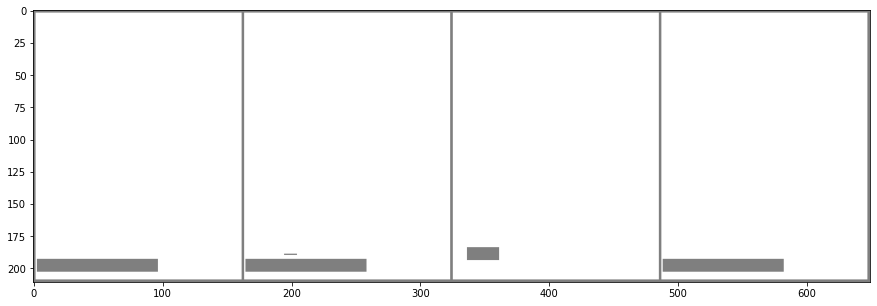

Labels:
    2              2              2              2


In [ ]:
# Visualize the validation data if grayscale 
# Code taken and adapted from Pytorch tutorial
#Labels 
classes = (0, 1, 2)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

batch = 8
# get some random training images
dataiter = iter(validate_loader)
images, labels = dataiter.next()
#print(images.size())
print(images.type())
#images = images.unsqueeze(1)
#print(type(np.float32(labels)))
# show images
imshow(torchvision.utils.make_grid(images, nrow = 4))
# print labels
print('Labels:')
print('          '.join('%5s' % classes[labels[j]] for j in range(val_batch)))

#Printing as RGB, just using basic pytorch dataloader likely converting to rbg

In [ ]:
 # Set to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_model(m, model_ext, device):

  if torch.cuda.is_available():
    print('First Model training on GPU')

    if m == 'First model':
      # Create model object 
      model = ConvNet()
      model = model.to(device)#(float).cuda()

    elif m == 'pre-trained':
      mPATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/cnn_512_662.model{}'.format(model_ext)
      model = ConvNet()
      model.load_state_dict(torch.load(mPATH))
      model.to(device)
      print('New Model{} training on GPU'.format(model_ext))
      

    elif m == 'resnet':
      model = models.resnet50(pretrained=True)
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, 3)
      model = model.to(device)
      print('RESNET Model training on GPU')
      

    elif m == 'pre-trained-res':
      mPATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/cnn_512_662.model{}'.format(model_ext)
      model = models.resnet50()
      num_ftrs = model.fc.in_features
      model.fc = nn.Linear(num_ftrs, 3)
      model.load_state_dict(torch.load(mPATH))
      model.to(device)
      print('New Model{} training on GPU'.format(model_ext))

  else:
    print("CUDA is not available. Turn on GPU")



  return model

In [ ]:

#original size: 2560, 3312
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    
    # without considering batch size: Input shape : (None,368, 284, 1) , parameters: (3*3*1*16+16) = 160
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, # one input channel gray scale, 16 filters out
                            kernel_size = 3, stride = 1, padding = 1) #Out:(None,386, 284, 16). ### TRY kernel 7x7 padding 3
    self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640                        
    self.pool1 = nn.MaxPool2d(2, 2) #Out: (None, 184, 142, 32) 
    self.bn1 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) #params: (3*3*16*32+32) = 4640    
    self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248                    
    self.pool2 = nn.MaxPool2d(2, 2) #Output shape = (None, 92, 71, 64) 
    self.bn2 = nn.BatchNorm2d(64)  

    #self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          #kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248 
    self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 128, 
                          kernel_size = 3, stride = 1, padding = 1) # params: (3*3*32*32+32) = 9248
    self.pool3 = nn.MaxPool2d(2, 2) #Output shape = (None, 46, 35, 128) 
    self.bn3 = nn.BatchNorm2d(128)
    self.do2 = nn.Dropout(0.3)
                                   
                             
    # Fully connected layer
    self.fc1 = nn.Linear(128*64*82,60) #most recent original size of: 512, 662 -->64 x 82
    self.do3 = nn.Dropout(0.4) #40 % probability  
    #self.fc3 = nn.Linear(60, 30)
    self.fc2 = nn.Linear(60, 3) # left with 3 for the three classes                     



  def forward(self, x):
    x = self.bn1(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
    x = self.bn2(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
    #x = self.bn3(self.pool3(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = self.bn3(self.pool3(F.relu(self.conv6((x)))))
    x = self.do2(x)
    x = x.view(x.size(0),128*64*82)
    x = F.relu(self.fc1(x))
    x = self.do3(x)
    x = self.fc2(x)
    return x                        
    
# Get model
model = set_model(m, model_ext, device)

# Print weights
#for param in model.parameters():
  #print(str(param.data.numpy().shape)+'\n')
  #print("weights fc1: ", model.fc1.weight)

# Loss function
criterion = nn.CrossEntropyLoss(reduction="mean")

# Optimizer (can use SGD or ADAM)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)#, momentum = 0.9) #or ADAM/ momentum
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay= weight_decay) 

#scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 4)

print(model)

accuracy_stats = {
    'train': [],
    'val': []
  }

print(accuracy_stats)

loss_stats = {
    'train': [],
    'val': []
    }
print(loss_stats)



def train_val_model(epochs):
  for epoch in range(1, epochs + 1):

    # TRAINING *****************************************************************

    train_epoch_loss = 0
    train_epoch_acc = 0

    # set model in training mode 
    model.train()
    print('\nEpoch$ : %d'%epoch)
    for x_train_batch, y_train_batch in tqdm(train_loader):
      x_train_batch = x_train_batch.to(device)#(float).to(device) # for GPU support
      y_train_batch = y_train_batch.to(device) 

      #print(x_train_batch.shape)

      # sets gradients to 0 to prevent interference with previous epoch
      optimizer.zero_grad()
    
      # Forward pass through NN
      y_train_pred = model(x_train_batch)#.to(float)
      train_loss = criterion(y_train_pred, y_train_batch)
      train_acc = accuracy(y_train_pred, y_train_batch)

      # Backward pass, updating weights
      train_loss.backward()
      optimizer.step()

      # Statistics
      train_epoch_loss += train_loss.item()
      train_epoch_acc += train_acc.item()


    # VALIDATION****************************************************************   
    
    with torch.set_grad_enabled(False):
      val_epoch_loss = 0
      val_epoch_acc = 0

      model.eval()
      for x_val_batch, y_val_batch in tqdm(validate_loader):
      
        x_val_batch =  x_val_batch.to(device)#.to(float)
        y_val_batch = y_val_batch.to(device)
            
        # Forward pass
        y_val_pred = model(x_val_batch)#.to(float)   
        val_loss = criterion(y_val_pred, y_val_batch)
        val_acc = accuracy(y_val_pred, y_val_batch)
            
        val_epoch_loss += val_loss.item()
        val_epoch_acc += val_acc.item()

    # Prevent plateauing validation loss 
    #scheduler.step(val_epoch_loss/len(validate_loader))

        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(validate_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(validate_loader))
                              
    
    print(f'Epoch {epoch+0:03}: Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(validate_loader):.5f}') 
    print(f'Train Acc: {train_epoch_acc/len(train_loader):.3f} | Val Acc: {val_epoch_acc/len(validate_loader):.3f}')

      




def accuracy(y_pred, y_test):
  # Calculating model accuracy at each epoch 
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_prob = torch.max(y_pred_softmax, dim = 1)
  correct_pred = (y_pred_prob == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  acc = torch.round(acc * 100)

  return acc



     





if __name__ == '__main__':
  train_val_model(15)
    

# added learning rate decay after 3rd epoch
# 1st: round 1
# 2nd: round 5
# 3rd: round 6 best so far
# 4th: round 7
# 5th (model) saved training on 9
# 6th: round 2
# 7th round 8
# 8th round 3
# 9th round 4
# 10th round 10

New Model3 training on GPU
ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.3, inplace=False)
  (fc1): Linea

  0%|          | 0/306 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 66/66 [00:22<00:00,  2.95it/s]


Epoch 001: Train Loss: 1.02604 | Val Loss: 1.29751
Train Acc: 44.160 | Val Acc: 33.333

Epoch$ : 2


100%|██████████| 66/66 [00:22<00:00,  2.91it/s]


Epoch 002: Train Loss: 0.75440 | Val Loss: 0.99522
Train Acc: 60.190 | Val Acc: 53.030

Epoch$ : 3


100%|██████████| 66/66 [00:22<00:00,  2.99it/s]


Epoch 003: Train Loss: 0.55158 | Val Loss: 0.81617
Train Acc: 71.627 | Val Acc: 59.470

Epoch$ : 4


100%|██████████| 66/66 [00:22<00:00,  2.93it/s]


Epoch 004: Train Loss: 0.38491 | Val Loss: 0.84523
Train Acc: 82.219 | Val Acc: 59.848

Epoch$ : 5


100%|██████████| 66/66 [00:21<00:00,  3.04it/s]


Epoch 005: Train Loss: 0.29537 | Val Loss: 0.76898
Train Acc: 87.314 | Val Acc: 64.773

Epoch$ : 6


100%|██████████| 66/66 [00:22<00:00,  2.98it/s]


Epoch 006: Train Loss: 0.21588 | Val Loss: 1.62177
Train Acc: 90.797 | Val Acc: 49.621

Epoch$ : 7


100%|██████████| 66/66 [00:21<00:00,  3.04it/s]


Epoch 007: Train Loss: 0.17185 | Val Loss: 0.89970
Train Acc: 92.248 | Val Acc: 65.152

Epoch$ : 8


100%|██████████| 66/66 [00:21<00:00,  3.03it/s]


Epoch 008: Train Loss: 0.15998 | Val Loss: 0.95171
Train Acc: 93.546 | Val Acc: 66.667

Epoch$ : 9


100%|██████████| 66/66 [00:25<00:00,  2.62it/s]


Epoch 009: Train Loss: 0.12999 | Val Loss: 0.85300
Train Acc: 94.477 | Val Acc: 73.106

Epoch$ : 10


100%|██████████| 66/66 [00:23<00:00,  2.84it/s]


Epoch 010: Train Loss: 0.10112 | Val Loss: 0.89766
Train Acc: 96.284 | Val Acc: 69.697

Epoch$ : 11


100%|██████████| 66/66 [00:22<00:00,  2.88it/s]


Epoch 011: Train Loss: 0.07533 | Val Loss: 1.06793
Train Acc: 97.154 | Val Acc: 65.152

Epoch$ : 12


100%|██████████| 66/66 [00:21<00:00,  3.06it/s]


Epoch 012: Train Loss: 0.08307 | Val Loss: 0.97336
Train Acc: 96.876 | Val Acc: 67.045

Epoch$ : 13


100%|██████████| 66/66 [00:22<00:00,  2.91it/s]


Epoch 013: Train Loss: 0.07184 | Val Loss: 0.99632
Train Acc: 97.395 | Val Acc: 70.076

Epoch$ : 14


100%|██████████| 66/66 [00:22<00:00,  2.98it/s]


Epoch 014: Train Loss: 0.05860 | Val Loss: 1.16737
Train Acc: 97.866 | Val Acc: 66.288

Epoch$ : 15


100%|██████████| 66/66 [00:22<00:00,  2.97it/s]

Epoch 015: Train Loss: 0.04050 | Val Loss: 1.19272
Train Acc: 98.582 | Val Acc: 69.318


# Visualize the Training and Validation


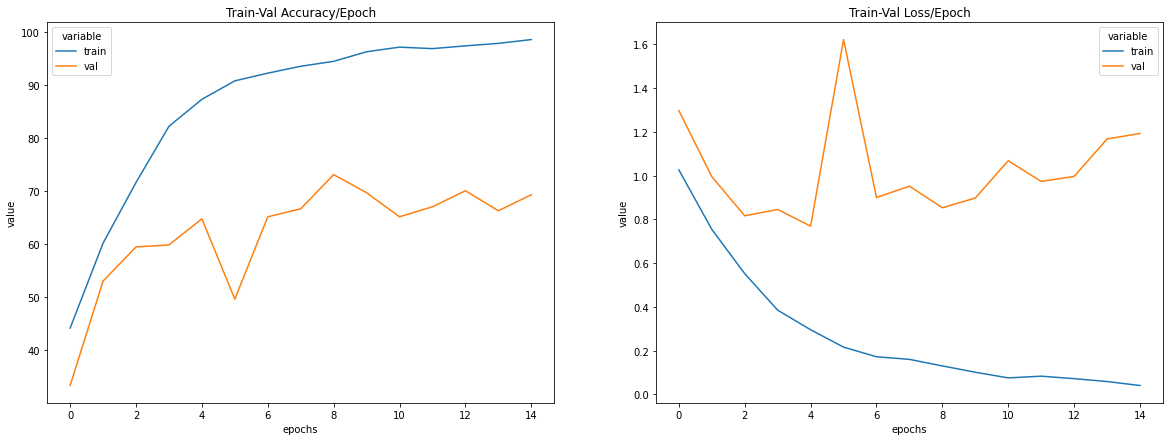

In [ ]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_acc_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/acc{}.csv'.format(extension_), index = False)
train_val_loss_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acc_loss/loss{}.csv'.format(extension_), index = False)
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/acc_loss{}.png'.format(extension_))

# Evaluate the model using Test Set

In [ ]:
# Calculate performance
y_test = torch.tensor([])
test_acc = torchmetrics.Accuracy()

with torch.set_grad_enabled(False):
  model.eval()
  #model.to(float)
  for batches in tqdm(test_loader):
    x_test, y_test = batches
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(x_test)
    test_acc(y_pred.cpu(), y_test.cpu())
    total_test_acc = test_acc.compute()
  print('test acc: ', total_test_acc)
  test_acc.reset()
   

100%|██████████| 254/254 [01:57<00:00,  2.16it/s]

test acc:  tensor(0.7047)


## Create Confusion Matrix

In [ ]:
all_pred = []
all_preds = torch.tensor([])
y_test = torch.tensor([])
with torch.set_grad_enabled(False):
  model.eval()
  for x_test_batch, y_test_batch in tqdm(test_loader):
    x_test_batch = x_test_batch.to(device)#.to(float).to(device)
    y_test_pred = model(x_test_batch)
    _, y_pred_probs = torch.max(y_test_pred, dim = 1)
    all_pred.append(y_pred_probs.cpu().numpy())
    all_preds = torch.cat((all_preds.cpu(), y_pred_probs.cpu()),dim = 0)
    y_test = torch.cat((y_test, y_test_batch), dim = 0) 

100%|██████████| 254/254 [01:53<00:00,  2.23it/s]


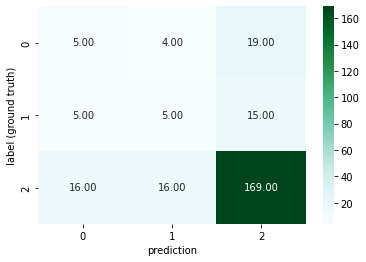

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, all_pred))#.rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/CMTX{}.png'.format(extension_))
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
#class_names = ["Possible Dementia", "Likely Dementia", "No Dementia"]
class_vals = [0,1,2]

cr = classification_report(y_test, all_pred, class_vals, output_dict = True)
try:
    cr_file = open('/content/gdrive/MyDrive/Colab Notebooks/model_charts/cr{}.txt'.format(extension_), 'wt')
    cr_file.write(str(cr))
    cr_file.close()
  
except:
    print("Unable to write to file")
print(classification_report(y_test, all_pred, class_vals))


              precision    recall  f1-score   support

           0       0.19      0.18      0.19        28
           1       0.20      0.20      0.20        25
           2       0.83      0.84      0.84       201

    accuracy                           0.70       254
   macro avg       0.41      0.41      0.41       254
weighted avg       0.70      0.70      0.70       254



# Plot ROC curve

ROC AUC score: 0.5662669026643127


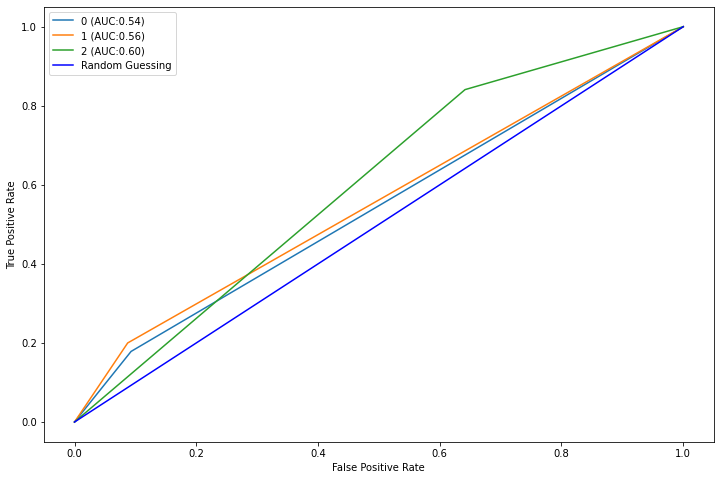

In [ ]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= [0, 1, 2]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test1, all_pred1, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test1)
    y_test1 = lb.transform(y_test1)
    all_pred1 = lb.transform(all_pred1)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test1[:,idx].astype(int), all_pred1[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test1, all_pred1, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, all_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/roc{}.png'.format(extension_))
plt.show()

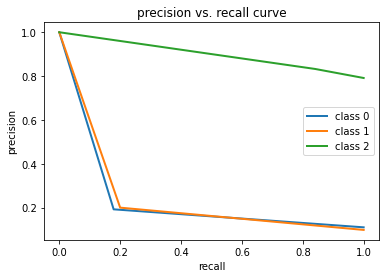

In [ ]:
# precision recall curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


# Use label_binarize to be multi-label like settings
y = y_test.numpy()
Y = label_binarize(y, classes=[0, 1, 2])
Y_pred = label_binarize(all_pred, classes=[0, 1, 2])
n_classes = Y.shape[1]

precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        Y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/model_charts/auc_pr{}.png'.format(extension_))
plt.show()

## Save the GPU CNN Model
Also includes loading on GPU

In [ ]:
# Save GPU model
model_name = 'cnn_512_662.model{}'.format(extension_)
PATH = "/content/gdrive/MyDrive/Colab Notebooks/Models/{}".format(model_name)
torch.save(model.state_dict(), PATH)

In [ ]:
"""# Load GPU model
device = torch.device("cuda")
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.to(device)"""

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    class_names = [0,1,2]
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validate_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j].squeeze().permute(2,1))# image1.squeeze().permute(1,2,0)
                #imshow(np.transpose(inputs.cpu().data[j], (2, 0, 1)))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)  